<a href="https://colab.research.google.com/github/Cho-Jh98/Self_Teaching/blob/main/%EC%9D%B8%EA%B3%B5%EC%A7%80%EB%8A%A5%EA%B0%9C%EB%A1%A0HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.utils.data.dataset import random_split

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchsummary import summary as summary_
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 기본적인 파라미터 설정
batch_size = 128
max_pool_kernel = 2
learning_rate = 0.0005
num_epochs = 30
num_classes = 10

datasets = torchvision.datasets.CIFAR10(root='./datasets',
                                        train=True,
                                        transform=transforms.ToTensor(),
                                        download=True)

train_dataset, val_dataset = random_split(datasets, [40000,10000])

test_dataset = torchvision.datasets.CIFAR10(root='./datasets',
                                       train=False,
                                       transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_dataset,
                        batch_size = batch_size, 
                        shuffle = True)
val_loader = DataLoader(dataset=val_dataset, 
                      batch_size = batch_size,
                      shuffle = False)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./datasets/cifar-10-python.tar.gz to ./datasets


In [ ]:
class ConvNet(nn.Module):
  def __init__(self, num_classes=10):
    super(ConvNet, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(3, 6, 5, stride=1, padding = 2, padding_mode = 'reflect'), #input : batch_size = 128, 3 channel, 32x32 pixel
        nn.BatchNorm2d(6),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) # output : batch_size = 128, 6 channel, 16x16 pixel
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(6, 16, 3, stride=1, padding=1), # input : batch_size = 128, 6 channel, 16x16 pixel
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) # ouput : batch_size = 128, 16 channel, 8x8 pixel
    )
    self.layer3 = nn.Sequential(
        nn.Conv2d(16, 32, 3, stride=1, padding=1), # input : batch_size = 128, 16 channel, 8X8 pixel
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) # output : batch_size = 128, 32 channel, 4x4 pixel
    )
    self.fc1 = nn.Linear(512, 120) # input : 32 x 4 x 4 = 512
    self.fc2 = nn.Linear(120, 80)
    self.fc3 = nn.Linear(80, num_classes)

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    
    x = x.reshape(x.size(0),-1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.softmax(self.fc3(x))
    return x

In [ ]:
model = ConvNet(num_classes).to(device)

In [ ]:
print("                model summary(print output shape)")
summary_(model,(3,32,32),batch_size=batch_size)

                model summary(print output shape)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [128, 6, 32, 32]             456
       BatchNorm2d-2           [128, 6, 32, 32]              12
              ReLU-3           [128, 6, 32, 32]               0
         MaxPool2d-4           [128, 6, 16, 16]               0
            Conv2d-5          [128, 16, 16, 16]             880
       BatchNorm2d-6          [128, 16, 16, 16]              32
              ReLU-7          [128, 16, 16, 16]               0
         MaxPool2d-8            [128, 16, 8, 8]               0
            Conv2d-9            [128, 32, 8, 8]           4,640
      BatchNorm2d-10            [128, 32, 8, 8]              64
             ReLU-11            [128, 32, 8, 8]               0
        MaxPool2d-12            [128, 32, 4, 4]               0
           Linear-13                 [128, 120]      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [ ]:
total_step = len(train_loader)
train_loss_list = [] 
train_loss_value = 0
val_loss_list = []
val_loss_value = 0
test_loss_list = [] 
test_loss_value = 0


train_acc_list = []
train_acc_value = 0
val_acc_list = []
val_acc_value = 0
test_acc_list = [] 
test_acc_value = 0

# Train
for epoch in range(num_epochs):
  correct = 0
  for i, (images, labels) in enumerate(train_loader):

    # Assign Tensors to Configured Device
    images = images.to(device)
    labels = labels.to(device)

    # Forward Propagation
    outputs = model(images)

    # Get Loss, Compute Gradient, Update Parameters
    loss_value = criterion(outputs, labels)
    train_loss_value += loss_value.item()
    optimizer.zero_grad()
    loss_value.backward()
    optimizer.step()

    # evaluate loss and accuracy of train data set
    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum().item()

  train_acc_value = correct / (len(train_loader) * batch_size) * 100
  train_loss_value = train_loss_value / len(train_loader)
  train_acc_list.append(train_acc_value)
  train_loss_list.append(train_loss_value) 
  
  # Print Loss for Tracking Training
  print('\n')
  print('Completed training Epoch', epoch + 1, 
        '\nTraining Accuracy: %.2f%%' %(train_acc_value),
        '\nTraining Loss: %.4f' %train_loss_value)
  
  with torch.no_grad(): 
    model.eval() 
    correct = 0
    for images, labels in val_loader:

      images = images.to(device)
      labels = labels.to(device)
      predicted_val_outputs = model(images) 
      val_loss_value += criterion(predicted_val_outputs, labels).item()
      _, val_predicted = torch.max(predicted_val_outputs, 1)
      correct += (val_predicted == labels).sum().item()
    
    val_acc_value = (correct/(len(val_loader) * batch_size)*100)
    val_acc_list.append(val_acc_value)
    val_loss_value = val_loss_value/len(val_loader)
    val_loss_list.append(val_loss_value)

    print('validation accuracy: {:.2f}%\nvalidation loss: {:.4f}'.format(val_acc_value, val_loss_value,))
    print('\n')
    print("=" * 35)

  with torch.no_grad(): 
    model.eval() 
    correct = 0
    for images, labels in test_loader:

      images = images.to(device)
      labels = labels.to(device)
      predicted_test_outputs = model(images) 
      test_loss_value += criterion(predicted_test_outputs, labels).item()
      _, test_predicted = torch.max(predicted_test_outputs, 1)
      correct += (test_predicted == labels).sum().item()
    
    test_acc_value = (correct/(len(test_loader) * batch_size)*100)
    test_acc_list.append(test_acc_value)
    test_loss_value = test_loss_value/len(test_loader)
    test_loss_list.append(test_loss_value)
    
  if epoch+1 == num_epochs:
    torch.save(model.state_dict(), 'model.pth')
  else:
    torch.save(model.state_dict(), 'model-{:02d}_epochs.pth'.format(epoch+1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.




Completed training Epoch 1 
Training Accuracy: 37.12% 
Training Loss: 2.0922
validation accuracy: 42.44%
validation loss: 2.0298




Completed training Epoch 2 
Training Accuracy: 46.34% 
Training Loss: 2.0019
validation accuracy: 43.13%
validation loss: 2.0442




Completed training Epoch 3 
Training Accuracy: 50.09% 
Training Loss: 1.9641
validation accuracy: 47.04%
validation loss: 2.0082




Completed training Epoch 4 
Training Accuracy: 53.06% 
Training Loss: 1.9360
validation accuracy: 54.08%
validation loss: 1.9402




Completed training Epoch 5 
Training Accuracy: 55.79% 
Training Loss: 1.9080
validation accuracy: 56.33%
validation loss: 1.9153




Completed training Epoch 6 
Training Accuracy: 56.93% 
Training Loss: 1.8972
validation accuracy: 55.96%
validation loss: 1.9172




Completed training Epoch 7 
Training Accuracy: 58.43% 
Training Loss: 1.8811
validation accuracy: 57.41%
validation loss: 1.9071




Completed training Epoch 8 
Training Accuracy: 60.04% 
Training Los

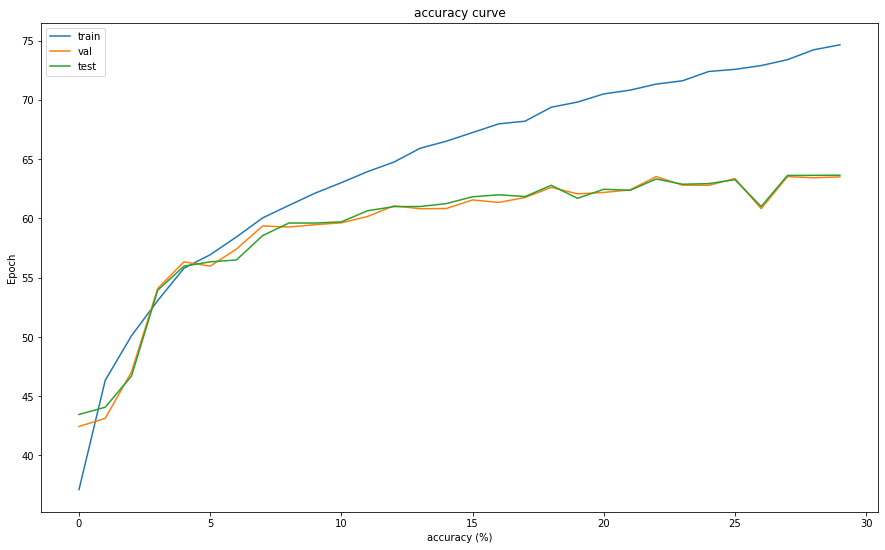

In [ ]:
## plot accuracy curve
acc_plot = plt.figure(figsize=(15,9))
acc_plot = plt.plot(train_acc_list, label = 'train')
acc_plot = plt.plot(val_acc_list, label = 'val')
acc_plot = plt.plot(test_acc_list, label = 'test')

acc_plot = plt.title('accuracy curve')
acc_plot = plt.xlabel('accuracy (%)')
acc_plot = plt.ylabel('Epoch')

acc_plot = plt.legend(loc='best')

plt.show(acc_plot)

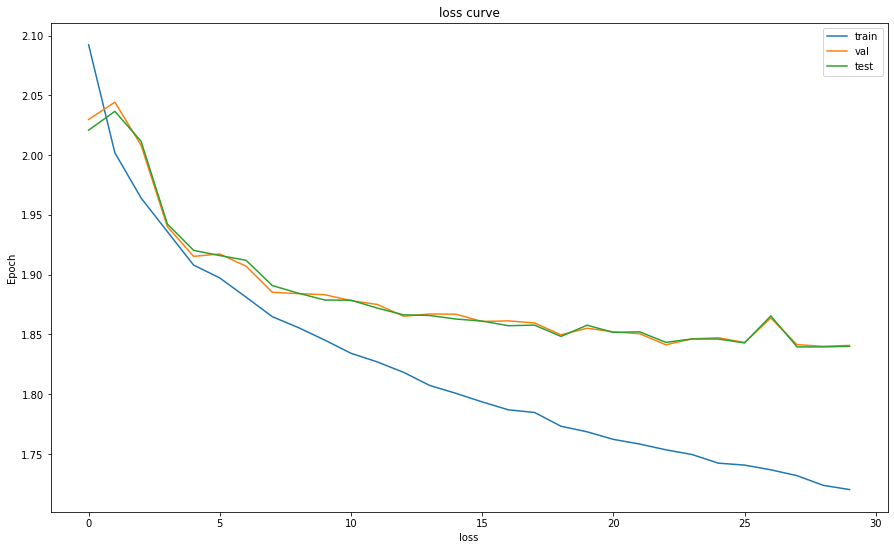

In [ ]:
## plot loss curve
loss_plot = plt.figure(figsize=(15,9))
loss_plot = plt.plot(train_loss_list, label = 'train')
loss_plot = plt.plot(val_loss_list, label = 'val')
loss_plot = plt.plot(test_loss_list, label = 'test')

loss_plot = plt.title('loss curve')
loss_plot = plt.xlabel('loss')
loss_plot = plt.ylabel('Epoch')

loss_plot = plt.legend(loc='best')
plt.show(acc_plot)

In [ ]:
test_model = ConvNet().to(device)

test_model.load_state_dict(torch.load('/Desktop/model.pth'))
test_model.eval()

correct = 0
with torch.no_grad(): # auto_grad off
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = test_model(images)
    _, predicted = torch.max(outputs.data, 1)
 
    correct += (predicted == labels).sum().item()
ㄴ
  print('Accuracy of the network on the {} test images {:.2f}%'.format(len(test_loader)*batch_size, 100*correct/(len(test_loader) * batch_size)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of the network on the 10112 test images 63.64%
